# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [82]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

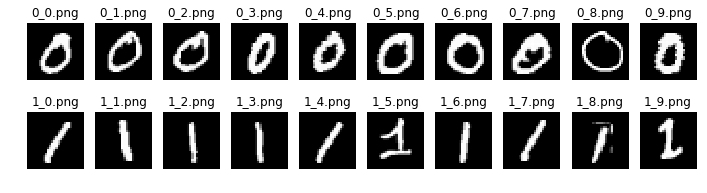

In [291]:
import skimage.io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy
from skimage import feature
import matplotlib.pyplot as plt

%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors


Let's start by considering the contourns of the images and define them as a complex number.

After we apply to them 'Fourier trasform' function to calculate the amplitude of the first 4 Fourier descriptors.

The descriptors are then saved in a pandas dataframe 'Features' 

In [361]:
def Fourier_trasform(N,fourier):
    feature=np.zeros((4))

    for l in range(4):
        summa=0
        for i in range(N):
            summa+=(fourier[i]*np.exp((-2 *l* np.pi * 1j *i )/N))
        feature[l]=np.abs(summa)
    
    return feature

In [383]:
Features=pd.DataFrame(index=np.arange(len(zeros_im)+len(ones_im)),columns=['Descriptor_0','Descriptor_1','Descriptor_2','Descriptor_3'])

#descriptor for zeros images
for m in range(len(zeros_im)):
    im2, contours, hierarchy = cv2.findContours(zeros_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    #find the biggest contour
    contour = sorted(contours, key = lambda x: len(x))[-1]
    fourier=np.zeros((len(contour),1),dtype=np.complex64)#contours[0] is the max len contours
    
    #trasform the contour coordinate into complex one
    for i, contours in enumerate(contour):
        
        fourier[i]=complex(contours[0][1],contours[0][0])
    
    Features.iloc[m,:]=Fourier_trasform(len(contour),fourier)

In [384]:
#descriptor for ones  images
for m in range(len(zeros_im)):
    im2, contours, hierarchy = cv2.findContours(ones_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    #find the biggest contour
    contour = sorted(contours, key = lambda x: len(x))[-1]
    fourier=np.zeros((len(contour),1),dtype=np.complex64)#contours[0] is the max len contours
    
    #trasform the contour coordinate into complex one
    for i, contours in enumerate(contour):
        
        fourier[i]=complex(contours[0][1],contours[0][0])
    
    Features.iloc[len(zeros_im)+m,:]=Fourier_trasform(len(contour),fourier)


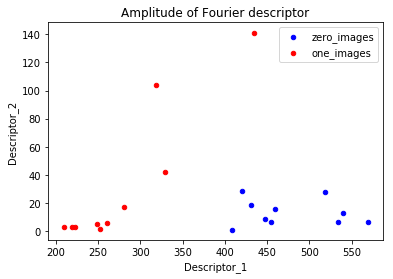

In [394]:
ax=Features.astype(int).iloc[:len(zeros_im),1:3].plot.scatter(x='Descriptor_1',y='Descriptor_2',c='Blue',label='zero_images')
Features.astype(int).iloc[len(zeros_im)::,1:3].plot.scatter(x='Descriptor_1',y='Descriptor_2',c='Red',ax=ax,label='one_images')
plt.title('Amplitude of Fourier descriptor')
plt.legend()
plt.show()                                                                          

TRASLATION AND ROTATION INVARIANCE OF FOURIER DESCRIPTORS

In this section, we will asses that the amplitude of Fourier descriptors (except for the first descriptor that represents the DC component) doesn't change if the image is rotated or traslated.

Let's consider a single image and its traslation.

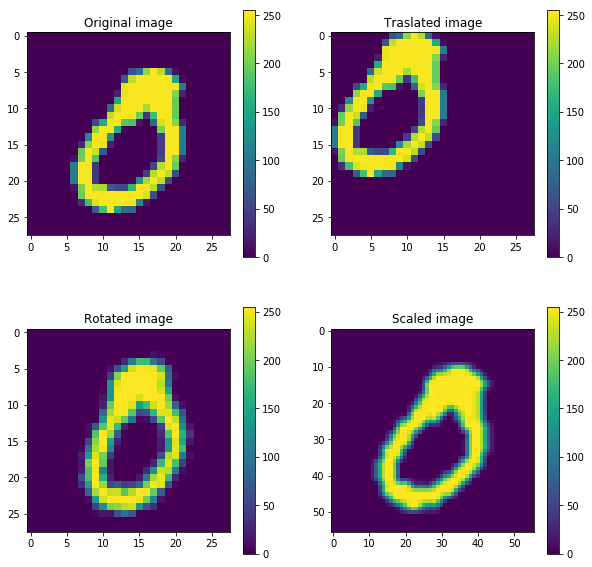

In [496]:
image=np.zeros((zeros_im[0,:,:].shape[0],zeros_im[0,:,:].shape[1]))
im2, contours, hierarchy = cv2.findContours(zeros_im[0,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
skeleton=cv2.drawContours(image, contours, 0, (255,255,255), 1)
for region in regionprops(skeleton.astype('int')):
        minr, minc, maxr, maxc = region.bbox
shift_x=np.abs(minr-maxr)
shift_y=np.abs(minc-maxc)
image=np.zeros((zeros_im[0,:,:].shape[0],zeros_im[0,:,:].shape[1]))
image[:shift_x,:shift_y]=(image[:shift_x,:shift_y]+1)*zeros_im[0,:,:][minr:maxr,minc:maxc]


rotated_image=skimage.transform.rotate(zeros_im[0,:,:],15)

#trasfor to have a scale from 0-255
rotated_image=np.round(rotated_image*255/np.max(rotated_image.ravel()))

#scale of a factor =1/10
height, width = zeros_im[0,:,:].shape
scaled_image = cv2.resize(zeros_im[0,:,:],(2*width, 2*height), interpolation = cv2.INTER_CUBIC)



plt.figure(figsize=(10,10))
plt.subplot(2,2,2)
plt.imshow(image)
plt.title('Traslated image')
plt.colorbar()

plt.subplot(2,2,1)
plt.imshow(zeros_im[0,:,:])
plt.title('Original image')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(rotated_image)
plt.title('Rotated image')
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(scaled_image)
plt.title('Scaled image')
plt.colorbar()
plt.show()


Since we know already the Fourier descriptor for the original image, let's find out the one for the traslated image

In [486]:
Modified_Descriptor=pd.DataFrame(index=[0,1,2,3],columns=['Descriptor_0','Descriptor_1 ','Descriptor_2','Descriptor_3 ' ])

#analysis of the traslated image
im2, contours, hierarchy = cv2.findContours(image.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contour = sorted(contours, key = lambda x: len(x))[-1]
fourier=np.zeros((len(contour),1),dtype=np.complex64)#contours[0] is the max len contours
    
    #trasform the contour coordinate into complex one
for i, contours in enumerate(contour):
        
        fourier[i]=complex(contours[0][1],contours[0][0])
    
Modified_Descriptor.iloc[0,:]=Fourier_trasform(len(contour),fourier)



In [487]:
#analysis of the rotated image


im2, contours, hierarchy = cv2.findContours(rotated_image.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contour = sorted(contours, key = lambda x: len(x))[-1]
fourier=np.zeros((len(contour),1),dtype=np.complex64)#contours[0] is the max len contours
    
    #trasform the contour coordinate into complex one
for i, contours in enumerate(contour):
        
        fourier[i]=complex(contours[0][1],contours[0][0])
    
Modified_Descriptor.iloc[1,:]=Fourier_trasform(len(contour),fourier)



In [497]:
#analysis for the scaled image
im2, contours, hierarchy = cv2.findContours(scaled_image.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contour = sorted(contours, key = lambda x: len(x))[-1]
fourier=np.zeros((len(contour),1),dtype=np.complex64)#contours[0] is the max len contours
    
    #trasform the contour coordinate into complex one
for i, contours in enumerate(contour):
        
        fourier[i]=complex(contours[0][1],contours[0][0])
    
Modified_Descriptor.iloc[2,:]=Fourier_trasform(len(contour),fourier)




In [469]:
Modified_Descriptor.iloc[1,:] #rotation

Descriptor_0     1155.43
Descriptor_1     506.054
Descriptor_2     29.5825
Descriptor_3     36.5393
Name: 1, dtype: object

In [468]:
Modified_Descriptor.iloc[0,:] #traslation

Descriptor_0     654.811
Descriptor_1     431.032
Descriptor_2     19.8729
Descriptor_3      24.445
Name: 0, dtype: object

In [403]:
Features.iloc[0,:]#intial

Descriptor_0    1057.25
Descriptor_1    431.032
Descriptor_2    19.8729
Descriptor_3     24.445
Name: 0, dtype: object

We can see that for the traslated image only the zero descriptor, so the DC component is changed, the other are the same.

For the rotated image instead, we have a sligtly different amplitude values. This is due to the fact that the function 'rotate' uses interpolation to reconstruct the rotated image, so we lose the initial pixel values, bringing to have different frequencies components respect the original one.


Let's consider the analisys of the scaled image:

In [502]:
Modified_Descriptor.iloc[2,:] /Modified_Descriptor.iloc[2,1]#scaled image

Descriptor_0       2.30751
Descriptor_1             1
Descriptor_2     0.0784925
Descriptor_3     0.0719859
Name: 2, dtype: object

In [503]:
Features.iloc[0,:]/Features.iloc[0,1] #original image

Descriptor_0      2.45283
Descriptor_1            1
Descriptor_2    0.0461053
Descriptor_3    0.0567128
Name: 0, dtype: object

Here we consider that the ration among the descriptor of the scaled and the original image should not changed!
The difference is quite small and is given again by the interpolation that it's done to rescale the image

### 1.3 Chamfer Distance


In this section we will describe a contour based description: the Chamfer Distance.
First of all, we select two templates for class 1 and 0 by visual detection( small number of training data allows to do it); then, we define their skeleton and applied the function 'distance_transform' to obtain the distance map.

The other images of one and zeros are then all compared with these two distance map of the templates and a measure of similariy is extracted, taking into account the rotation and traslation invariance.

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [ ]:
from skimage.morphology import skeletonize
from skimage.util import invert



#template for zeros
image_zeros = (zeros_im[8,:,:])
image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))
im2, contours, hierarchy = cv2.findContours(image_zeros, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
skeleton=cv2.drawContours(image, contours, -1, (255,255,255), 1)
#plt.imshow(skeleton,cmap='gray')
skeleton=np.where(skeleton==255,0,1)
skeleton=np.pad(skeleton, (15, 15), 'edge')
distance_map_zeros=scipy.ndimage.morphology.distance_transform_cdt(skeleton)

plt.subplot(1,2,1)
plt.imshow(distance_map_zeros)
plt.title('Distance map for zeros')


#template for ones
image_ones = (ones_im[7,:,:])
image=np.ones((image_ones.shape[0],image_ones.shape[1]))
im2, contours, hierarchy = cv2.findContours(image_ones, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
skeleton=cv2.drawContours(image, contours, -1, (255,255,255), 1)
#plt.imshow(skeleton,cmap='gray')

skeleton=np.where(skeleton==255,0,1)
skeleton=np.pad(skeleton, (15, 15), 'edge')# adding padding to prevent the problme of rotation
distance_map_ones=scipy.ndimage.morphology.distance_transform_cdt(skeleton)

plt.subplot(1,2,2)
plt.imshow(distance_map_ones)
plt.title('Distance map for ones')
plt.show()


Now, let's calculate the similarity between the other images and the two templates above.
We take the optimal trasformation of the images that minimizes the distance respect to both the templates. The distance will be the features used to classify the images.


In [ ]:
def similarity(input1,input2,previous_distance,angle,i,j):
    distance=np.sum(input1*input2)
    if distance<previous_distance:
           return distance,angle,i,j
    else: 
          return None

In [ ]:
#zeros and ones
def features_calculation(distance_map_zeros,shift_x,shift_y,skeleton,m):
    previous_distance=np.sum(distance_map_zeros.ravel()) #max possible value
    #traslation
    for i in range(0,distance_map_zeros.shape[0]-shift_x):
        for j in range(0,distance_map_zeros.shape[1]-shift_y):
            
            
            
            for angle in np.arange(0,360,10):
                img_rot = skimage.transform.rotate((skeleton.astype('float')),angle,resize=True)
                img_rot=np.where(img_rot>=np.mean(img_rot),1,0)#super bad but it's done to have binary images
                
                if (img_rot.shape> skeleton.shape)& ((i+img_rot.shape[0]<=distance_map_zeros.shape[0]) &( j+img_rot.shape[1]<=distance_map_zeros.shape[1])) :
                   
                    if similarity(img_rot,distance_map_zeros[i:i+img_rot.shape[0],j:j+img_rot.shape[1]],previous_distance,angle,i,j)!=None :
                        min_distance,min_angle,min_trasl_x,min_trasl_y= similarity(img_rot,distance_map_zeros[i:i+img_rot.shape[0],j:j+img_rot.shape[1]],previous_distance,angle,i,j)
                        previous_distance=min_distance
                        
                elif (img_rot.shape== skeleton.shape):
                   
                    if (similarity(img_rot,distance_map_zeros[i:i+shift_x,j:j+shift_y],previous_distance,angle,i,j)!=None): 
                        min_distance,min_angle,min_trasl_x,min_trasl_y= similarity(img_rot,distance_map_zeros[i:i+shift_x,j:j+shift_y],previous_distance,angle,i,j)
                        previous_distance=min_distance
                
            
            
            
        
            #
    print('Image: 0{}, min_distance:{}, angle:{}, traslation:[{},{}]'.format(m,previous_distance,min_angle,min_trasl_x,min_trasl_y ))            
    return min_distance

In [ ]:
from skimage.measure import regionprops
import pandas as pd
import matplotlib.patches as mpatches

features=pd.DataFrame(index=np.arange(0,len(zeros_im)+len(ones_im)), columns=['Features0','Features1'])
image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))

#all zeros images:
for m in range(len(zeros_im)):
    #find the contour of the image and threhsolding the contour
    im2, contours, hierarchy = cv2.findContours(zeros_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton=cv2.drawContours(image-1, contours, -1, (255,255,255), 1)
    skeleton=np.where(skeleton==255,1,0)
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    min_distance=features_calculation(distance_map_zeros,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],m)
    features.iloc[m,0]=min_distance
    min_distance=features_calculation(distance_map_ones,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],m)
    features.iloc[m,1]=min_distance
    
    image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))
    

#all the ones images
image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))
for n in range(len(ones_im)):
    
#find the contour of the image and threhsolding the contour
    im2, contours, hierarchy = cv2.findContours(ones_im[n,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    skeleton=cv2.drawContours(image-1, contours, -1, (255,255,255), 1)
    skeleton=np.where(skeleton==255,1,0)
    for region in regionprops(skeleton):
        minr, minc, maxr, maxc = region.bbox
    shift_x=np.abs(minr-maxr)
    shift_y=np.abs(minc-maxc)
    
    min_distance=features_calculation(distance_map_zeros,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],n)
    features.iloc[m+n+1,0]=min_distance
    min_distance=features_calculation(distance_map_ones,shift_x,shift_y,skeleton[minr:maxr,minc:maxc],n)
    features.iloc[m+n+1,1]=min_distance
    image=np.ones((image_zeros.shape[0],image_zeros.shape[1]))

In [ ]:
ax=features.iloc[0:len(zeros_im),:].plot.scatter(x='Features0',y='Features1',c='Blue')
features.iloc[len(zeros_im)::,:].plot.scatter(x='Features0',y='Features1',c='Red',ax=ax)
plt.title('Features space')
plt.show()

In [ ]:
features

limitation of the method:

1) find a good template, 

2) resize image and trasform to binary

3) even though still two cluster could be identify !!

# FREEMANN

In [ ]:
#no approximation because we want the relationship among all the points!!
#for the zero there are three contous while for one just one contours, 
# we should treat them separately !!!
import pandas as pd
cm=pd.Series([5 ,6 ,7, 4,'nan', 0, 3, 2, 1])

freeman_code_zero=[]
#for zero, take the one with biggest area
for m in range(len(zeros_im)):
    max_cont=0
    im2, contours, hierarchy = cv2.findContours(zeros_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for i in range(len(contours)):
        if max_cont<len(contours[i]):
            contours[0]=contours[i]
            max_cont=len(contours[0])
            
    sb=np.roll(contours[0],(-1, -1),axis=(0,1))
    delta=sb-contours[0]
    if (np.abs(delta[-1][-1][1])>1) | (np.abs(delta[-1][-1][0])>1):
        delta=delta[0:len(delta)-1,:]
    idx=np.zeros((len(delta)))
    for i in range(len(delta)):
        idx[i]=3*delta[i][0][1] + delta[i][0][0]+4;

    freeman_code_zero.append(cm[idx.astype(int)].values)#remember two for one image



#for one , just one cases
freeman_code_one=[]
for m in range(len(ones_im)):
    im2, contours, hierarchy = cv2.findContours(ones_im[m,:,:], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if (len(contours)>1):
        if(len(contours[0])<len(contours[1])):
            contours[0]=contours[1]
        
    sb=np.roll(contours[0],(-1, -1),axis=(0,1))
    delta=sb-contours[0]
    if (np.abs(delta[-1][-1][1])>1) | (np.abs(delta[-1][-1][0])>1):
        delta=delta[0:len(delta)-1,:]
    idx=np.zeros((len(delta)))
    for i in range(len(delta)):
        idx[i]=3*delta[i][0][1] + delta[i][0][0]+4;
        
    freeman_code_one.insert(m, cm[idx.astype(int)].values)



In [ ]:

#
#
#  used direction-to-code convention is:        (5) (6) 7
#%                                                \ | /
#%                                             4 -- P -- 0
#%                                                / | \
#%                                              3 (2)  (1)
#%   

#% Then use a mapping array cm
#%   --------------------------------------
#%   | deltax | deltay | code | (base-3)+1 |
#%   |-------------------------------------|
#%   |    0   |   +1   |   2  |      8     | 
#%   |    0   |   -1   |   6  |      2     | 
#%   |   -1   |   +1   |   3  |      7     | 
#%   |   -1   |   -1   |   5  |      1     | 
#%   |   +1   |   +1   |   1  |      9     | 
#%   |   +1   |   -1   |   7  |      3     | 
#%   |   -1   |    0   |   4  |      4     |  
#%   |   +1   |    0   |   0  |      6     | 
#%   ---------------------------------------



In [ ]:
import numpy as np
from scipy.stats import entropy # calculate kl divergence #http://scipy.github.io/devdocs/generated/scipy.stats.entropy.html
np.set_printoptions(precision=2)
# https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm
# Original Paper http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.367.5281&rep=rep1&type=pdf
deletion_cost = 1
insertion_cost = 1
substitution_cost = 1
def fisher_wagner(line1, line2):
    #print("Fisher Wagner Distance: %s => %s"%(line1,line2))
    #print("Operations:")
    #print("\ti(X) means that character 'X' gets inserted in the resulting string at the current position")
    #print("\tn(X,X) means that two charcters were equal, no operation required")
    #print("\ts(X,Y) means that the character 'X' gets substituted with 'Y' at the current position ")
    #print("\td(X) means that character 'X' gets deleted from the current position")
    #print("\tNote: n(,), the noop for comparing empty string to empty string has been ommitted for clarity")
    # distance matrix
    d = np.zeros(shape=(len(line1)+1, len(line2)+1))
    ops = np.ndarray(shape=(len(line1)+1, len(line2)+1), dtype=np.dtype('S100') )
    ops[:] = ""  #clear array
    # ops[0,0] = "n( , )"
    for i in range(1,len(line1)+1):
            d[i,0] = d[i-1,0] + deletion_cost # the distance of any first string to an empty second string requires i deletions
            ops[i, 0] = "%sd(%c)"%(ops[i-1,0],line1[i-1])
    for j in range(1,len(line2)+1):
            d[0, j] = d[0,j-1] + insertion_cost# the distance of any second string to an empty first string
            ops[0,j] = "%si(%c)"%(ops[0,j-1],line2[j-1])
    #print("Cost matrix for empty strings")
    #print(d)
    #print("Operation matrix for empty strings")
    #print(ops)
    for j in range(1,len(line2)+1):
        for i in range(1,len(line1)+1):
                char1 = line1[i-1] # because strings in python are also zero indexed
                char2 = line2[j-1] # because strings in python are also zero indexed
                #print("\nStep(i=%i,j=%i)"%(i, j))
                #print("Goal: %s => %s"%(line1[0:i],line2[0:j]))
                #print("Comparing: '%s' to '%s'"%(char1, char2))
                if char1 == char2:
                    #print("\t=> equal, no change required")
                    d[i, j] = d[i-1, j-1]
                    ops[i,j]="%sn(%c,%c)"%(ops[i-1, j-1],char1,char2)
                else:
                    #print("\t=> not equal, need to modify something")
                    del_op_cost = d[i-1,j  ] + deletion_cost     # deletion
                    ins_op_cost = d[i  ,j-1] + insertion_cost    # insertion
                    subs_op_cost   = d[i-1,j-1] + substitution_cost # substitution_cost
                    #print("\tCost of reaching goal via del:  %sd(%c): %i"%(ops[i-1, j], char1, del_op_cost))
                    #print("\tCost of reaching goal via ins:  %si(%c): %i"%(ops[i ,j-1], char2, ins_op_cost))
                    #print("\tCost of reaching goal via sub:  %ss(%c,%c): %i"%(ops[i-1, j-1], char1, char2, subs_op_cost))
                # assign performed operation
                    if del_op_cost<ins_op_cost and del_op_cost<subs_op_cost:
                                        ops[i,j]="%sd(%c)"%(ops[i-1, j], char1)
                    elif ins_op_cost<del_op_cost and ins_op_cost<subs_op_cost:
                                        ops[i,j]="%si(%c)"%(ops[i ,j-1], char2)
                    else: # substitution
                                        ops[i,j]="%ss(%c,%c)"%(ops[i-1, j-1], char1, char2)
                    d[i, j] = min(del_op_cost, ins_op_cost, subs_op_cost)
                                       
                    #print("Cost Matrix:")
                    #print(d)
                    #print("Traces Matrix:")
                    #print(ops)
    #print(d)           
    return d[len(line1), len(line2)]#3,2
#print(fisher_wagner("ABV", "FV"))


In [ ]:
#import fischer_wagner_explained
fisher_wagner('1234', '16')

In [ ]:
template_zeros=freeman_code_zero[6]
template_ones=freeman_code_one[7]

features=pd.DataFrame(index=np.arange(0,len(zeros_im)+len(ones_im)), columns=['Features0','Features1'])
for i in range(len(freeman_code_zero)):
    features.iloc[i,0]=fisher_wagner(freeman_code_zero[i],template_zeros)
    features.iloc[i,1]=fisher_wagner(freeman_code_zero[i],template_ones)
for j in range(len(freeman_code_one)):
    features.iloc[i+j+1,0]=fisher_wagner(freeman_code_one[j],template_zeros)
    features.iloc[i+j+1,1]=fisher_wagner(freeman_code_one[j],template_ones)
        

In [ ]:
features

In [ ]:
ax=features.iloc[0:len(zeros_im),:].plot.scatter(x='Features0',y='Features1',c='Blue')
features.iloc[len(zeros_im)::,:].plot.scatter(x='Features0',y='Features1',c='Red',ax=ax)
plt.title('Features space')
plt.legend(['zeros','ones'])
plt.show()

The division in classes is really hard and this is due to the completely different shape that both zero and ones have and also due to a bad segmentation.